In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME="./config_bdd.csv"
tuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in tuxdata:
    ft = tuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
        # categorical variable
        #if tuxdata[col].dtype == 'object':
        #    try:
        #        tuxdata[col] = tuxdata[col].astype('category')
        #    except:
        #        print('Column', ' ', col, ' cannot be converted to category.')
    else:
        non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
non_tristate_options.remove('vmlinux')


#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))
# maybe we can drop options with only one unique value (no interest for machine learning)
tuxdata.drop(columns=ftuniques,inplace=True)

print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))

print ("Predictor variables: " + str(tuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()
    



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11858,12340,12341,12378,12384) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of options with only one value (eg always y): (3420, 1)
Non tri-state value options (eg string or integer or hybrid values): (164, 1) 
Predictor variables: 9235


In [2]:
# playing a bit with the data 
tuxdata['vmlinux']
tuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

tuxdata[:5]
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,FONT_10x18,FONT_SUN8x16,FONT_SUN12x22,FONT_AUTOSELECT,SG_SPLIT,SG_POOL,STACKDEPOT,SBITMAP,PARMAN,PRIME_NUMBERS
0,72510,2018-07-04 01:41:29,296.145,59662336,9371920,11461888,9148088,13635856,15725272,9294831,...,n,n,n,n,n,y,y,y,n,n
1,72511,2018-07-04 01:41:32,376.601,349815544,10478544,12563576,10330903,14283728,16368208,10018508,...,n,n,n,n,n,y,y,y,n,y
2,72512,2018-07-04 01:42:41,243.444,24504992,6132688,8218072,5985836,10101712,12186536,5834097,...,n,n,n,n,n,y,y,y,n,n
3,72513,2018-07-04 01:45:48,468.959,143764936,33648592,35734992,33501176,34533328,36619176,30268716,...,n,n,n,n,n,y,n,y,n,n
4,72514,2018-07-04 01:46:21,158.348,34353912,6549456,8637136,6339572,10682320,12769448,6354591,...,n,n,n,n,n,n,y,n,y,y


In [3]:
#from category_encoders import *
from sklearn.preprocessing import *

#X = [['y', 1], ['n', 3], ['m', 2]]
#enc.fit(X)
#enc.transform(tuxdata)

#enc = OrdinalEncoder().fit(tuxdata[:10])

# transform the dataset
#enc.transform(tuxdata[:10])

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
#print(non_tristate_options)

# we save quantitative values we want (here vmlinux, TODO: generalize)
# the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
vml = tuxdata['vmlinux'] 


# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
tuxdata = tuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
tuxdata['vmlinux'] = vml 

#print(tuxdata.duplicated(subset=["vmlinux"]))
tuxdata.drop_duplicates(subset=["vmlinux"], inplace=True)

# example: DEBUG_INFO is either y or n
tuxdata['DEBUG_INFO'].unique()

array([0, 1])

In [4]:
#n_failures = len(tuxdata["vmlinux"] == -1)
#print(str(n_failures) + " failures out of " + str(len(tuxdata)))

#tuxdata = tuxdata.where(tuxdata["vmlinux"] != -1)
#tuxdata["vmlinux"]
#tuxdata.where(tuxdata["vmlinux"] == np.NaN)

#tuxdata[tuxdata["vmlinux"] != -1]
#tuxdata


,GENERIC_ISA_DMA,GENERIC_BUG,GENERIC_BUG_RELATIVE_POINTERS,ARCH_MAY_HAVE_PC_FDC,HAVE_INTEL_TXT,X86_64_SMP,CONSTRUCTORS,BROKEN_ON_SMP,COMPILE_TEST,LOCALVERSION_AUTO,...,FONT_SUN8x16,FONT_SUN12x22,FONT_AUTOSELECT,SG_SPLIT,SG_POOL,STACKDEPOT,SBITMAP,PARMAN,PRIME_NUMBERS,vmlinux
0,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,1,1,1,1,1,59662336
1,1,1,1,1,0,0,0,1,0,1,...,0,0,0,0,1,1,1,1,2,349815544
2,1,1,1,1,0,1,0,0,0,1,...,0,0,0,0,1,1,1,1,1,24504992
3,1,1,1,1,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,1,143764936
4,0,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,1,0,2,2,34353912
5,1,1,1,1,0,0,1,1,0,0,...,0,0,0,0,1,0,1,1,1,62163000
6,0,1,1,0,0,0,1,1,0,1,...,1,1,0,0,1,1,1,1,2,-1
8,0,1,1,0,0,0,0,1,1,0,...,0,0,0,1,1,1,1,2,1,23944088
9,1,1,1,1,0,1,1,0,1,0,...,1,0,0,0,1,1,1,1,0,40713872
10,1,1,1,1,0,1,0,0,0,1,...,0,0,0,0,1,1,1,1,2,83263080


In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor



TESTING_SIZE=0.1 

# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)

X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  
clf = GradientBoostingRegressor(n_estimators=100) # RandomForestRegressor(n_estimators=100) # 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]    

TOP_FT_IMPORTANCE=20
print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
for f in range(TOP_FT_IMPORTANCE): # len(indices)
    print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances for size of vmlinux")
#plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
#plt.xticks(range(tuxdata.shape[1]), indices)
#plt.xlim([-1, tuxdata.shape[1]])
#plt.show()
mae = mean_absolute_error (y_test, y_pred)
mse = mean_squared_error (y_test, y_pred) 
r2 = r2_score (y_test, y_pred) 
print("Prediction score (MAE): %.2f" % (mae))
print("Prediction score (MSE): %.2f" % (mse))
print("Prediction score (R2): %.2f" % (r2))


Feature ranking: top (20)
1. feature FB_MODE_HELPERS 5508 (0.023513)
2. feature EDAC_PND2 6859 (0.015674)
3. feature DRM_MEDFIELD 5430 (0.015274)
4. feature INPUT_MAX8925_ONKEY 3367 (0.014337)
5. feature INTEL_TURBO_MAX_3 7531 (0.013901)
6. feature EDAC_DECODE_MCE 6842 (0.012431)
7. feature HID_LOGITECH_DJ 6290 (0.011739)
8. feature FB_TFT_UPD161704 7404 (0.011646)
9. feature EDAC_I7CORE 6853 (0.011559)
10. feature TOUCHSCREEN_DA9034 3268 (0.008929)
11. feature COMEDI_AMPLC_PC236_ISA 7146 (0.008697)
12. feature VIDEO_MT9T001 5192 (0.008612)
13. feature SENSORS_LIS3_SPI 1833 (0.008603)
14. feature NFS_FSCACHE 8497 (0.008524)
15. feature INTEL_SCU_WATCHDOG 4405 (0.008232)
16. feature MFD_SPMI_PMIC 4543 (0.007840)
17. feature SND_MTS64 5716 (0.007622)
18. feature BAYCOM_PAR 1278 (0.007570)
19. feature RTC_DRV_BRCMSTB 6875 (0.007417)
20. feature GREYBUS_ARCHE 7442 (0.007400)
Prediction score (MAE): 56086480.64
Prediction score (MSE): 7832501158694269.00
Prediction score (R2): -0.41


<Figure size 432x288 with 0 Axes>

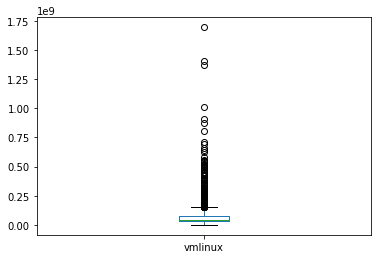

In [6]:
plt.figure()
pd.DataFrame(tuxdata['vmlinux']).plot.box()
plt.show()

In [7]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

True

In [8]:
tuxdata.where(tuxdata["vmlinux"] != -1).sort_values(by='vmlinux')[:5] # & 

,GENERIC_ISA_DMA,GENERIC_BUG,GENERIC_BUG_RELATIVE_POINTERS,ARCH_MAY_HAVE_PC_FDC,HAVE_INTEL_TXT,X86_64_SMP,CONSTRUCTORS,BROKEN_ON_SMP,COMPILE_TEST,LOCALVERSION_AUTO,...,FONT_SUN8x16,FONT_SUN12x22,FONT_AUTOSELECT,SG_SPLIT,SG_POOL,STACKDEPOT,SBITMAP,PARMAN,PRIME_NUMBERS,vmlinux
1926,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,7317008.0
1176,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,11662056.0
1972,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,12721864.0
419,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,12773448.0
1427,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,13028016.0


In [9]:
# basic_head = ["cid","time","compile","vmlinux","GZIP-bzImage","GZIP-vmlinux","GZIP","BZIP2-bzImage","BZIP2-vmlinux","BZIP2","LZMA-bzImage","LZMA-vmlinux","LZMA","XZ-bzImage","XZ-vmlinux","XZ","LZO-bzImage","LZO-vmlinux","LZO","LZ4-bzImage","LZ4-vmlinux","LZ4"]
